In [1]:
import pandas as pd
import sys
import os
from sentence_transformers import SentenceTransformer
import umap
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz

In [2]:
df = pd.read_csv('~/Documents/papers/iass-mcc-twitter-colab/data/all_tweets.csv',lineterminator='\n')
df = df[~df.text.str.match('^RT @')]
print(df.shape)
df.head()

(2498212, 4)


,id,created_at,text,author_id
0,1408295995507568642,2021-06-25 05:28:24+00:00,"‘’Today, it’s residents of inner-city Sydney t...",267570919
1,1413014175731773440,2021-07-08 05:56:46+00:00,“ Johnson is fed up with the rules. Collective...,267570919
2,1414403414679703554,2021-07-12 01:57:07+00:00,“It took a while for Reaganism to arrive in Au...,267570919
3,1430320029644455941,2021-08-25 00:04:03+00:00,“The question is not whether Australians want ...,267570919
4,1411115958031187973,2021-07-03 00:13:56+00:00,References to Morrison’s so called plan as cha...,267570919


In [3]:
author_df = pd.read_csv('~/Documents/papers/iass-mcc-twitter-colab/data/all_parliamentarians.csv').rename(columns={"id":"author_id"})
print(author_df.shape)
author_df.head()

(2368, 13)


,Nachname,Vorname,Fraktion,Twitter-Name,region,"Name, Vorname",Vorname Nachname,handle,party,parltype,person__in_parlperiod,lcasehandle,author_id
0,Ahrens,Sandra,CDU,@sandraAhrens,Bremen,NaN,NaN,sandraAhrens,CDUCSU,Land,NaN,sandraahrens,2.565034e+08
1,Aulepp,Sascha Karolin,SPD,NaN,Bremen,NaN,NaN,NaN,SPD,Land,NaN,NaN,NaN
2,Averwerser,Yvonne,CDU,@Yaverwerser,Bremen,NaN,NaN,Yaverwerser,CDUCSU,Land,NaN,yaverwerser,1.135974e+18
3,Beck,Peter,Liberal-Konservative Reformer,NaN,Bremen,NaN,NaN,NaN,other,Land,NaN,NaN,NaN
4,Bensch,Rainer,CDU,@BenschRainer,Bremen,NaN,NaN,BenschRainer,CDUCSU,Land,NaN,benschrainer,8.905828e+17


In [4]:
df = df.merge(author_df[['author_id','region','party','parltype']],how="left")
print(df.shape)
df.head()

(2503162, 7)


,id,created_at,text,author_id,region,party,parltype
0,1408295995507568642,2021-06-25 05:28:24+00:00,"‘’Today, it’s residents of inner-city Sydney t...",267570919,NaN,NaN,NaN
1,1413014175731773440,2021-07-08 05:56:46+00:00,“ Johnson is fed up with the rules. Collective...,267570919,NaN,NaN,NaN
2,1414403414679703554,2021-07-12 01:57:07+00:00,“It took a while for Reaganism to arrive in Au...,267570919,NaN,NaN,NaN
3,1430320029644455941,2021-08-25 00:04:03+00:00,“The question is not whether Australians want ...,267570919,NaN,NaN,NaN
4,1411115958031187973,2021-07-03 00:13:56+00:00,References to Morrison’s so called plan as cha...,267570919,NaN,NaN,NaN


In [5]:
df = df[pd.notna(df['party'])]
df = df[df['region']=="Bund"]
df['party'] = df['party'].str.upper()

df.shape

(1137113, 7)

In [6]:
df.created_at = pd.to_datetime(df['created_at'])
cutoff = datetime.datetime(2021,1,1,tzinfo=pytz.UTC)

df = df[df['created_at']>cutoff]
df = df.set_index('created_at')
print(df.shape)
df.head()

(157261, 6)


,id,text,author_id,region,party,parltype
created_at,,,,,,
2021-08-24 09:11:23+00:00,1430095381593985024,"@rainerfaus @bertpsch Ja, im Freundes- und Bek...",52024480,Bund,GRUENE,Bund
2021-09-02 07:35:26+00:00,1433332723985391616,"""Wir müssen Raum schaffen"", sagt Janecek, Raum...",52024480,Bund,GRUENE,Bund
2021-08-09 22:16:01+00:00,1424857024454696968,„Baerbocks Rede dreht sich zunächst vor allem ...,52024480,Bund,GRUENE,Bund
2021-08-24 06:42:55+00:00,1430058016997617683,"Ich freue mich, kommenden Montag die Spitzenka...",52024480,Bund,GRUENE,Bund
2021-06-21 22:08:05+00:00,1407098021989470218,Wenn der Technologieturbo so gut funktioniert ...,52024480,Bund,GRUENE,Bund


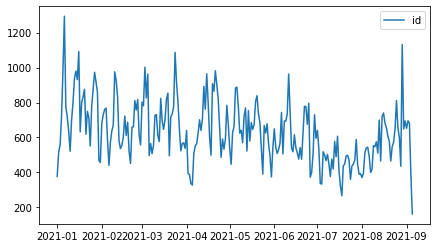

In [7]:
fig, ax = plt.subplots(figsize=(7,4))
counts = df.groupby(df.index.date)['id'].count().astype(int).to_frame()
counts.plot(ax=ax)

In [8]:
redo = False

if redo:

    import spacy
    nlp = spacy.load('de_core_news_sm')

    def lemmatize(doc):
        doc = nlp(doc)
        result = ' '.join([x.lemma_ for x in doc if not x.is_stop and not x.lemma_=="der"]) 
        return result

    df['clean_text'] = df.text.str.replace("(?:\@|https?\://)\S+", "").str.strip()
    df['clean_text'] = df.clean_text.str.replace("&amp;","")
    df['clean_text'] = df['clean_text'].apply(lemmatize)
    
    df.to_csv('source_data/lemmatized_tweets.csv',index=False)
    
else:
    
    df = pd.read_csv('source_data/lemmatized_tweets.csv',lineterminator='\n').dropna()
    
df.head()

,id,text,author_id,region,party,parltype,clean_text
0,1430095381593985024,"@rainerfaus @bertpsch Ja, im Freundes- und Bek...",52024480,Bund,GRUENE,Bund,"ja , Freundes- Bekanntenkreis . In sozial Netz..."
1,1433332723985391616,"""Wir müssen Raum schaffen"", sagt Janecek, Raum...",52024480,Bund,GRUENE,Bund,""" ich Raum schaffen "" , Janecek , Raum zugunst..."
2,1424857024454696968,„Baerbocks Rede dreht sich zunächst vor allem ...,52024480,Bund,GRUENE,Bund,"„ Baerbocks reden drehen Bildungspolitik , Sch..."
3,1430058016997617683,"Ich freue mich, kommenden Montag die Spitzenka...",52024480,Bund,GRUENE,Bund,"ich freuen , kommend Montag Spitzenkandidatin ..."
4,1407098021989470218,Wenn der Technologieturbo so gut funktioniert ...,52024480,Bund,GRUENE,Bund,wenn Technologieturbo funktionieren Södersche ...


In [9]:
# 5 What hashtags are most commonly used

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
regex = r'\B(?!#[0-9_]+\b)(#\w{2,30})\b'

sub_df = df.reset_index()

vec =  CountVectorizer(min_df=1, token_pattern=regex)
X = vec.fit_transform(sub_df.text)
features = vec.get_feature_names()

hashtags = pd.DataFrame()
hashtags['hashtag'] = features

hashtags['total'] = np.array(X.sum(axis=0)).ravel()   

for p in df.party.unique():
    print('\n',p,'\n')
    idx = sub_df[sub_df.party==p].index
    fcounts = np.array(X[idx,:].sum(axis=0)).ravel()   
    hashtags[p] = fcounts
    sorted_counts = np.argsort(fcounts)
    for x in sorted_counts[-10:]:
        print(fcounts[x],features[x])


 GRUENE 

331 #csu
367 #bonn
378 #corona
413 #afghanistan
426 #btw21
429 #cdu
429 #bundestag
475 #laschet
509 #allesistdrin
711 #klimaschutz

 LINKE 

283 #noafd
342 #bundesregierung
345 #btw21
367 #afghanistan
386 #cdurausausderregierung
428 #linke
515 #bundestag
530 #cdu
628 #wirecard
737 #corona

 CDUCSU 

152 #berlin
175 #scholz
184 #eu
205 #cdupt21
223 #spd
339 #bundestag
340 #wirecard
376 #cdu
384 #corona
420 #wegenmorgen

 SPD 

120 #scholzpacktdasan
120 #csu
146 #klimaschutz
160 #thewsdirekt
185 #wirecard
197 #laschet
246 #bundestag
267 #cdu
310 #corona
491 #spd

 AFD 

468 #altenburgerland
479 #greiz
502 #deutschlandabernormal
508 #wk194
532 #wirholendasdirektmandat
550 #gera
788 #brandner
877 #berlin
1052 #bundestag
2194 #afd

 FDP 

156 #mpk
174 #btw21
185 #eu
227 #lockdown
244 #bpt21
260 #bundestag
271 #bundesregierung
477 #vielzutun
564 #fdp
619 #corona


In [10]:
# All hashtags
pd.options.display.max_rows = 999
hashtags.sort_values('total',ascending=False).head(500).to_csv('results/top_hashtags.csv',index=False)
hashtags.sort_values('total',ascending=False).head(10)

,hashtag,total,GRUENE,LINKE,CDUCSU,SPD,AFD,FDP
3128,#bundestag,2841,429,515,339,246,1052,260
3863,#corona,2811,378,737,384,310,383,619
346,#afd,2451,37,32,65,72,2194,51
3504,#cdu,2004,429,530,376,267,257,145
23493,#wirecard,1592,249,628,340,185,38,152
2118,#berlin,1505,128,107,152,104,877,137
19662,#spd,1296,203,142,223,491,121,116
2984,#btw21,1281,426,345,146,95,95,174
390,#afghanistan,1215,413,367,125,106,82,122
12458,#laschet,1183,475,264,87,197,87,73


In [11]:
# 5 What hashtags are most commonly used

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
regex = r'\b(?<!#)(\w{2,30})\b'

sub_df = df.reset_index()

vec =  TfidfVectorizer(min_df=1, token_pattern=regex,sublinear_tf=True)
vec =  CountVectorizer(min_df=1, token_pattern=regex)
term_X = vec.fit_transform(sub_df.clean_text)
term_features = vec.get_feature_names()

terms = pd.DataFrame()
terms['hashtag'] = term_features

terms['total'] = np.array(term_X.sum(axis=0)).ravel()   

for p in df.party.unique():
    print('\n',p,'\n')
    idx = sub_df[sub_df.party==p].index
    fcounts = np.array(term_X[idx,:].sum(axis=0)).ravel()   
    terms[p] = fcounts
    sorted_counts = np.argsort(fcounts)
    for x in sorted_counts[-10:]:
        print(fcounts[x],term_features[x])


 GRUENE 

996 danken
1069 cdu
1153 innen
1194 klimaschutz
1243 mensch
1337 jahr
1392 brauchen
1570 und
1648 mein
7275 ich

 LINKE 

1148 corona
1165 bundestag
1182 innen
1318 mal
1404 aber
1404 jahr
1596 und
1647 mensch
2000 mein
9446 ich

 CDUCSU 

712 land
713 mensch
714 heute
779 jahr
785 mal
848 cdu
907 danken
971 und
1723 mein
7021 ich

 SPD 

842 sein
929 the
959 aber
1002 mensch
1164 mal
1181 spd
1198 jahr
1664 und
1711 mein
8302 ich

 AFD 

642 mal
645 jahr
677 deutschland
783 und
820 brandner
1014 mein
1040 berlin
1258 bundestag
2706 afd
4122 ich

 FDP 

955 jahr
955 mensch
979 danken
1046 und
1185 brauchen
1226 corona
1430 fdp
1532 mein
2613 tb
8137 ich


In [28]:
terms.sort_values('total',ascending=False).head(500).to_csv('results/top_terms.csv',index=False)
terms.sort_values('total',ascending=False).head(10)

,hashtag,total,GRUENE,LINKE,CDUCSU,SPD,AFD,FDP
48448,ich,44303,7275,9446,7021,8302,4122,8137
66219,mein,9628,1648,2000,1723,1711,1014,1532
103172,und,7630,1570,1596,971,1664,783,1046
52040,jahr,6318,1337,1404,779,1198,645,955
66477,mensch,5918,1243,1647,713,1002,358,955
64508,mal,5728,922,1318,785,1164,642,897
17507,bundestag,5499,968,1165,655,756,1258,697
16354,brauchen,5375,1392,1102,659,827,210,1185
20318,corona,5089,737,1148,675,678,625,1226
2033,aber,4891,794,1404,537,959,398,799


In [14]:
# 5 What hashtags are most commonly used

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
regex = r'\b(?<!#)(\w{2,30})\b'

sub_df = df.reset_index()

vec =  TfidfVectorizer(min_df=1, token_pattern=regex,sublinear_tf=True)
vec =  CountVectorizer(min_df=1, token_pattern=regex, ngram_range=(2,2))
bigram_X = vec.fit_transform(sub_df.clean_text)
bigram_features = vec.get_feature_names()

bigrams = pd.DataFrame()
bigrams['hashtag'] = bigram_features

bigrams['total'] = np.array(bigram_X.sum(axis=0)).ravel()   

for p in df.party.unique():
    print('\n',p,'\n')
    idx = sub_df[sub_df.party==p].index
    fcounts = np.array(bigram_X[idx,:].sum(axis=0)).ravel()   
    bigrams[p] = fcounts
    sorted_counts = np.argsort(fcounts)
    for x in sorted_counts[-10:]:
        print(fcounts[x],bigram_features[x])


 GRUENE 

108 robert habeck
111 letzt jahr
111 ich finden
114 zum beispiel
116 viel dank
170 csu spd
265 ich freuen
310 herzliche glückwunsch
419 cdu csu
523 ich brauchen

 LINKE 

104 viel dank
108 mieter innen
112 ich fordern
130 herzliche glückwunsch
153 ich freuen
156 corona krise
209 ich finden
215 cdu csu
226 die linke
411 ich brauchen

 CDUCSU 

102 ich mal
103 ich wünsche
108 mindestens impfen
108 ich finden
122 olaf scholz
145 steineke fürsieda
162 viel dank
194 ich freuen
219 ich brauchen
257 herzliche glückwunsch

 SPD 

97 zum beispiel
103 olaf scholz
109 delta variante
116 of the
133 ich finden
142 viel dank
187 cdu csu
192 ich freuen
242 ich brauchen
303 herzliche glückwunsch

 AFD 

194 deutschlandabernormal wirholendasdirektmandat
194 thüringen deutschlandabernormal
212 wirholendasdirektmandat gera
254 afd thüringen
364 greiz altenburgerland
427 gera greiz
431 altenburgerland wk194
474 wk194 berlin
776 bundestag brandner
784 berlin bundestag

 FDP 

104 frei demokrat
1

In [17]:
bigrams.sort_values('total',ascending=False).head(500).to_csv('results/top_bigrams.csv',index=False)
bigrams.sort_values('total',ascending=False).head(50)

,hashtag,total,GRUENE,LINKE,CDUCSU,SPD,AFD,FDP
463853,ich brauchen,1901,523,411,219,242,58,448
443617,herzliche glückwunsch,1230,310,130,257,303,40,190
465186,ich freuen,1055,265,153,194,192,52,199
184053,cdu csu,1049,419,215,72,187,59,97
127671,berlin bundestag,797,1,0,7,5,784,0
1008905,viel dank,779,116,104,162,142,63,192
173343,bundestag brandner,776,0,0,0,0,776,0
465047,ich finden,678,111,209,108,133,29,88
467126,ich mal,512,63,99,102,92,60,96
1098125,zum beispiel,499,114,89,93,97,24,82


In [19]:
term_topics = pd.read_excel('data/woerter_und_hashtags_v3.xlsx')
term_topics.head()

,hashtag,topic,Unnamed: 2
0,bundestag,politik-intern,NaN
1,corona,corona,NaN
2,cdu,parteien,NaN
3,danken,zusammenhalt,NaN
4,afd,parteien,NaN


In [27]:
topics = []
for topic, group in term_topics.groupby('topic'):
    topics.append(topic)
    df[topic]=0
    cloc = df.columns.get_loc(topic)
    for term in group.hashtag.unique():
        term = str(term)
        if "#" in term:
            x = X
            feat = features
        else:
            x = term_X
            feat = term_features
            term_id = np.argwhere(np.array(feat)==term).ravel()
            idx = x[:,term_id].nonzero()[0] 
            df.iloc[idx,cloc] = 1

In [30]:
topic_ds = [
    {"name":"digitales","keywords":[
        "digital\w* *bildung",
        "digital\w* *verwaltung",
        "^(?=.*5g)(?!.*(impf|covid|pandemie|corona)).*",
        "automatisier(en|t|ung)",
        "digitale\w* *\w*ämt"
    ]},
    {"name":"verkehr","keywords": ["^(?=.*auto)(?!.*matisier).*",]},
    {"name": "arbeit", "keywords": ["beruf(?!en)"]},
    {"name": "außenpolitik", "keywords": ["vereint\w* *nationen","(?<!ent)rüstung"]},
    {"name": "familien", "keywords": ["^(?=.*familien)(?!.*(angehörige|opfer)).*"]},
    {"name": "wohnen", "keywords": ["bauen\W*bauen\W*bauen"]},
    {"name": "gewalt", "keywords": ["^(?=.*gewalt)(?!.*(vierte|dritte)).*"]}
]
topic_names = []
redo = True
for t in topic_ds:
    print(t)
    if t["name"] not in topics:
        topics.append(t["name"])
    for term in t["keywords"]:
        df.loc[df['text'].str.lower().str.contains(term.lower()),t["name"]] = 1

df.head()

{'name': 'digitales', 'keywords': ['digital\\w* *bildung', 'digital\\w* *verwaltung', '^(?=.*5g)(?!.*(impf|covid|pandemie|corona)).*', 'automatisier(en|t|ung)', 'digitale\\w* *\\w*ämt']}


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


{'name': 'verkehr', 'keywords': ['^(?=.*auto)(?!.*matisier).*']}
{'name': 'arbeit', 'keywords': ['beruf(?!en)']}
{'name': 'außenpolitik', 'keywords': ['vereint\\w* *nationen', '(?<!ent)rüstung']}
{'name': 'familien', 'keywords': ['^(?=.*familien)(?!.*(angehörige|opfer)).*']}
{'name': 'wohnen', 'keywords': ['bauen\\W*bauen\\W*bauen']}
{'name': 'gewalt', 'keywords': ['^(?=.*gewalt)(?!.*(vierte|dritte)).*']}


,id,text,author_id,region,party,parltype,clean_text,0,?,agrar,...,sozialpolitik,staat,verkehr,wahlen,wirtschaft,wissenschaft,wohnen,zukunft,zusammenhalt,familien
created_at,,,,,,,,,,,,,,,,,,,,,
2021-08-24 09:11:23+00:00,1430095381593985024,"@rainerfaus @bertpsch Ja, im Freundes- und Bek...",52024480,Bund,GRUENE,Bund,"ja , Freundes- Bekanntenkreis . In sozial Netz...",0,0,0,...,1,0,0,0,0,0,0,0,0,NaN
2021-09-02 07:35:26+00:00,1433332723985391616,"""Wir müssen Raum schaffen"", sagt Janecek, Raum...",52024480,Bund,GRUENE,Bund,""" ich Raum schaffen "" , Janecek , Raum zugunst...",0,0,0,...,0,1,1,0,1,0,0,0,0,NaN
2021-08-09 22:16:01+00:00,1424857024454696968,„Baerbocks Rede dreht sich zunächst vor allem ...,52024480,Bund,GRUENE,Bund,"„ Baerbocks reden drehen Bildungspolitik , Sch...",0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2021-08-24 06:42:55+00:00,1430058016997617683,"Ich freue mich, kommenden Montag die Spitzenka...",52024480,Bund,GRUENE,Bund,"ich freuen , kommend Montag Spitzenkandidatin ...",0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2021-06-21 22:08:05+00:00,1407098021989470218,Wenn der Technologieturbo so gut funktioniert ...,52024480,Bund,GRUENE,Bund,wenn Technologieturbo funktionieren Södersche ...,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


In [31]:
df.to_csv('source_data/ht_term_annotated_tweets.csv',index=False)

In [32]:
cdict = {'afd': '#009EE0',
 'bp': None,
 'cducsu': '#000000',
 'dp': None,
 'drp': None,
 'dzp': None,
 'fdp': '#FFED00',
 'fraktionslos': None,
 'gb/bhe': None,
 'gruene': '#64A12D',
 'kpd': None,
 'linke': '#8C3473',
 'other': None,
 'parteilos': None,
 'pds': None,
 'spd': '#EB001F',
 'wav': None}

In [25]:
if type(df.index) == pd.core.indexes.numeric.Int64Index:
    df_times = pd.read_csv('~/Documents/papers/iass-mcc-twitter-colab/data/all_tweets.csv',lineterminator='\n')
    df_times['created_at'] = pd.to_datetime(df_times['created_at'])
    df = df.merge(df_times[['id','created_at']])
    df = df.set_index("created_at")
    
df.head()

,id,text,author_id,region,party,parltype,clean_text,0,?,agrar,...,sozialpolitik,staat,verkehr,wahlen,wirtschaft,wissenschaft,wohnen,zukunft,zusammenhalt,familien
created_at,,,,,,,,,,,,,,,,,,,,,
2021-08-24 09:11:23+00:00,1430095381593985024,"@rainerfaus @bertpsch Ja, im Freundes- und Bek...",52024480,Bund,GRUENE,Bund,"ja , Freundes- Bekanntenkreis . In sozial Netz...",0,0,0,...,1,0,0,0,0,0,0,0,0,NaN
2021-09-02 07:35:26+00:00,1433332723985391616,"""Wir müssen Raum schaffen"", sagt Janecek, Raum...",52024480,Bund,GRUENE,Bund,""" ich Raum schaffen "" , Janecek , Raum zugunst...",0,0,0,...,0,1,1,0,1,0,0,0,0,NaN
2021-08-09 22:16:01+00:00,1424857024454696968,„Baerbocks Rede dreht sich zunächst vor allem ...,52024480,Bund,GRUENE,Bund,"„ Baerbocks reden drehen Bildungspolitik , Sch...",0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2021-08-24 06:42:55+00:00,1430058016997617683,"Ich freue mich, kommenden Montag die Spitzenka...",52024480,Bund,GRUENE,Bund,"ich freuen , kommend Montag Spitzenkandidatin ...",0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2021-06-21 22:08:05+00:00,1407098021989470218,Wenn der Technologieturbo so gut funktioniert ...,52024480,Bund,GRUENE,Bund,wenn Technologieturbo funktionieren Södersche ...,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


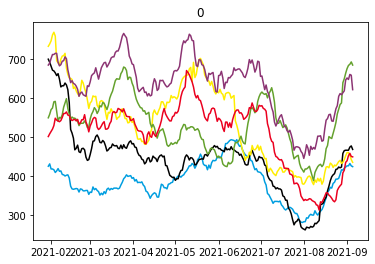

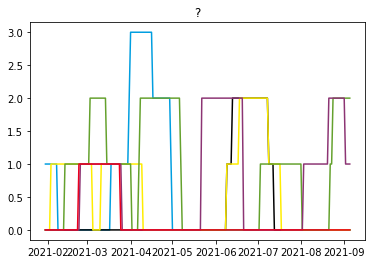

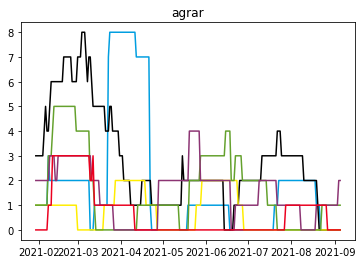

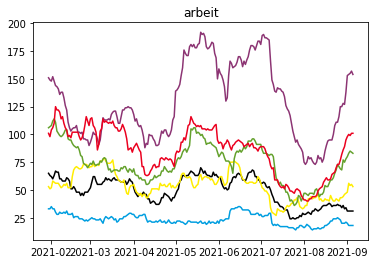

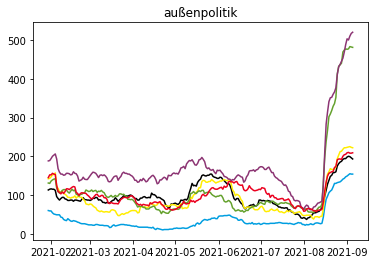

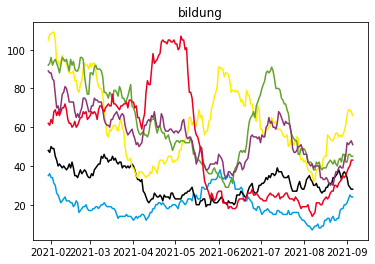

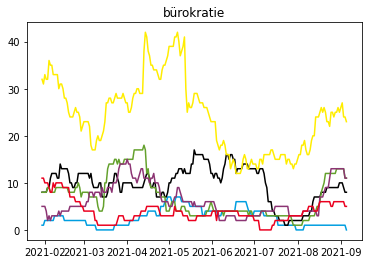

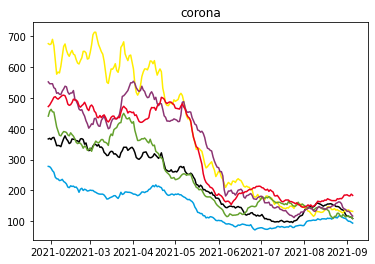

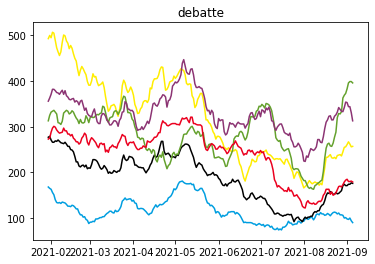

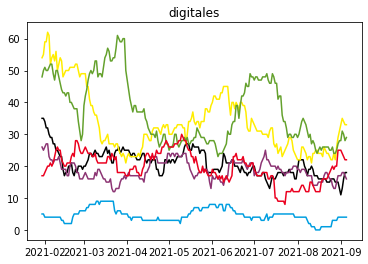

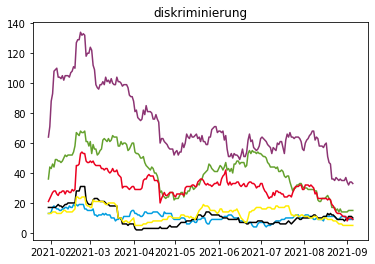

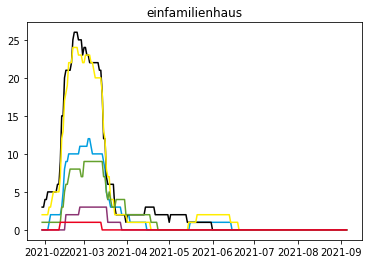

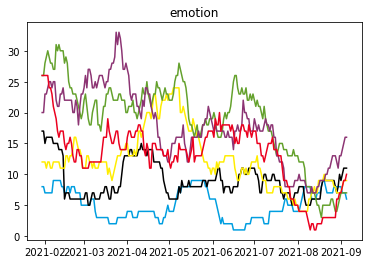

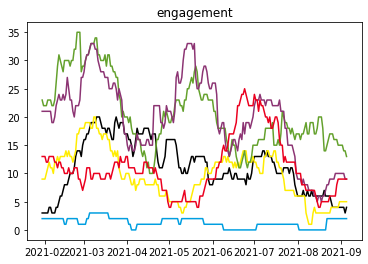

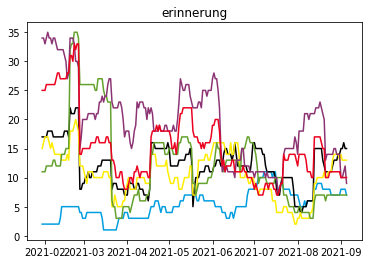

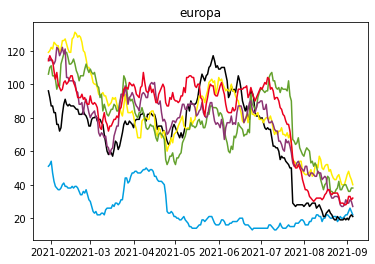

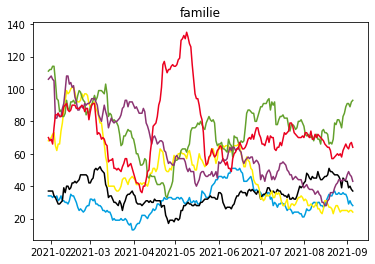

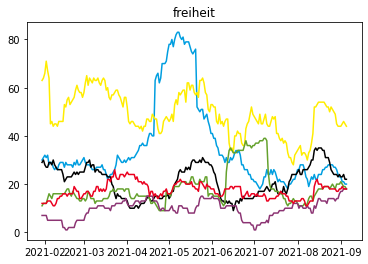

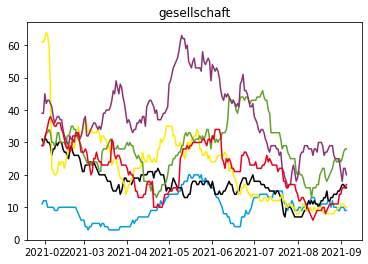

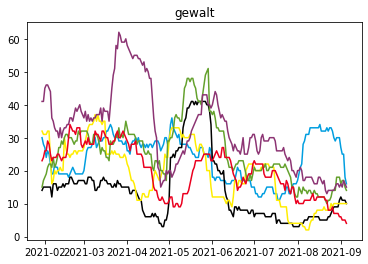

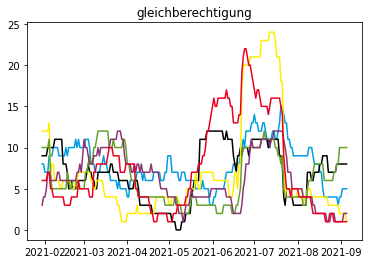

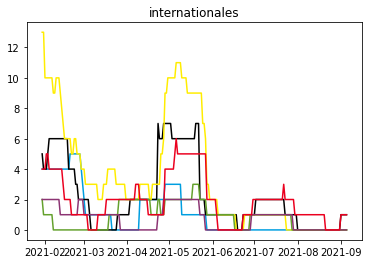

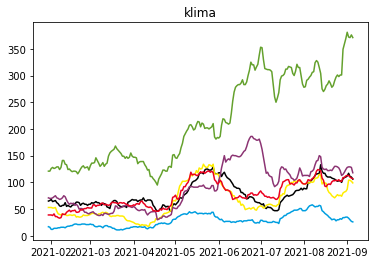

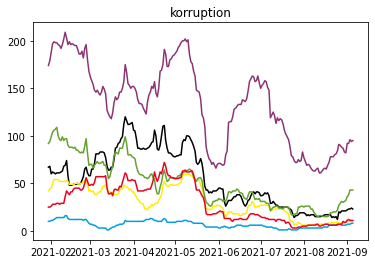

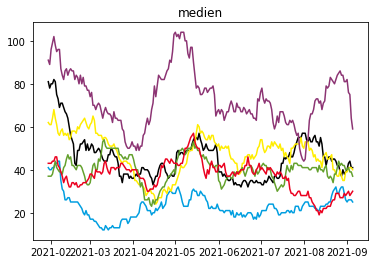

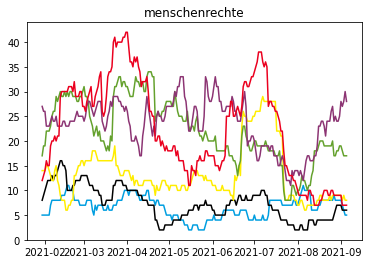

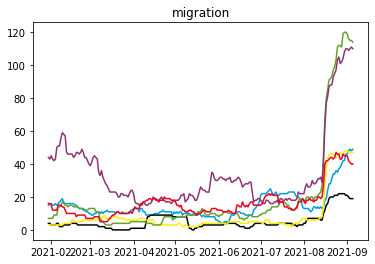

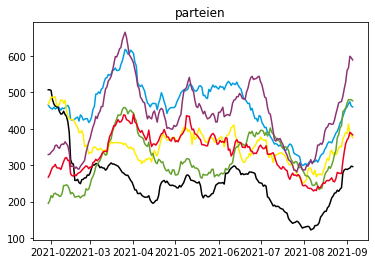

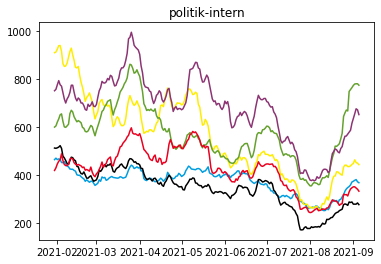

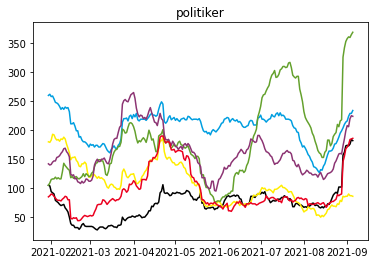

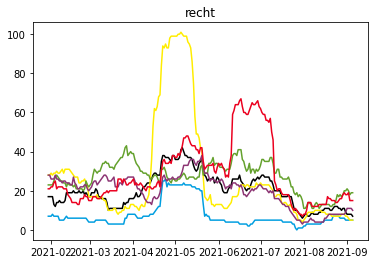

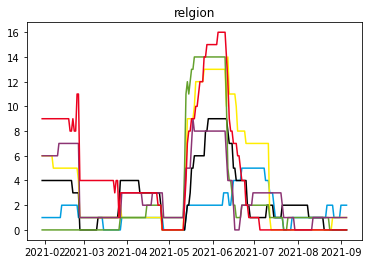

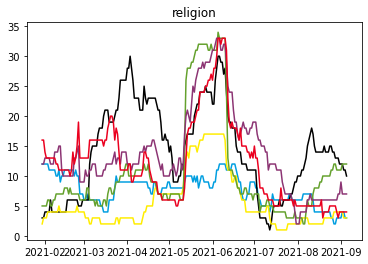

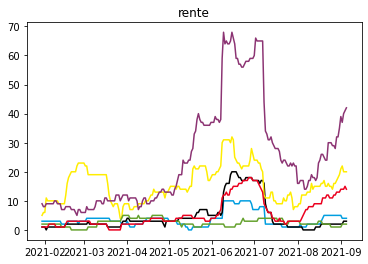

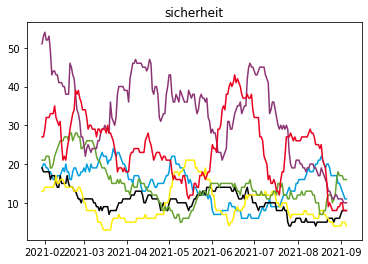

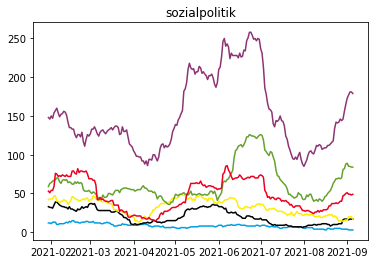

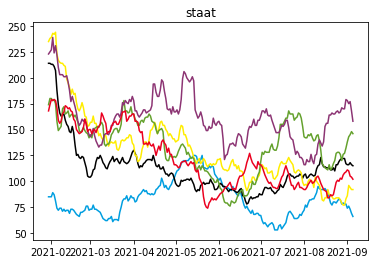

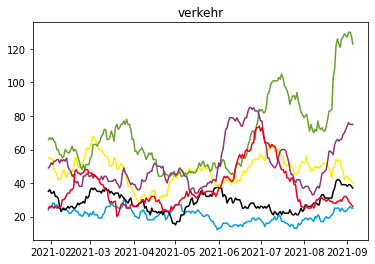

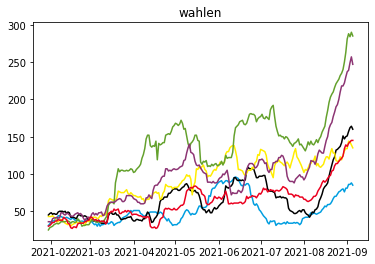

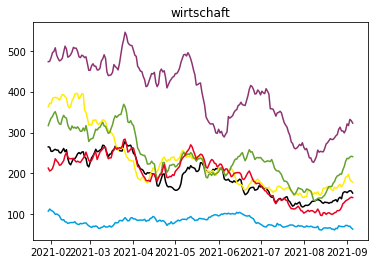

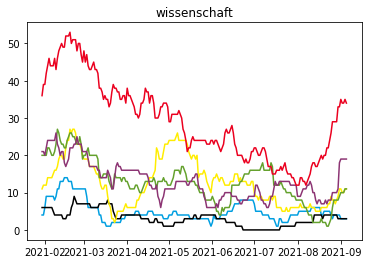

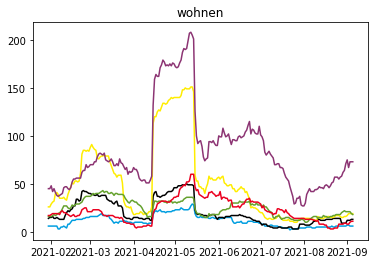

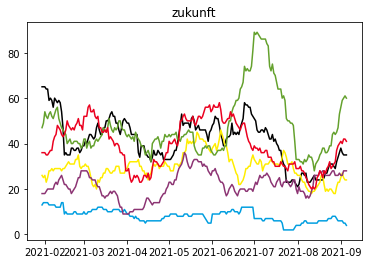

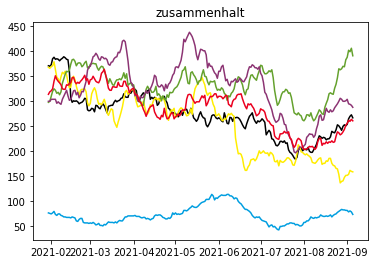

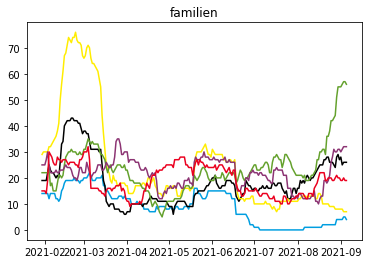

In [33]:


for j,c in enumerate(topics):
    
    fig, ax = plt.subplots()

    for party, group in df.groupby('party'):
        counts = group.groupby(group.index.date)[c].sum()
        counts = counts.rolling(30).sum()
        
        ax.plot(counts, color=cdict[party.lower()])
    
    ax.set_title(c)
    
    plt.show()
    
#     plt.savefig(f"plots/topic/topic_attention_{c.replace('/','_')}.png",bbox_inches="tight")
#     plt.savefig(f"plots/topic/topic_attention_{c.replace('/','_')}.pdf",bbox_inches="tight")